In [13]:
import os
import numpy as np
import tensorflow as tf
import json
import shutil
import heapq
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage.segmentation import slic,quickshift,felzenszwalb
from xplique.plots import plot_attributions
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP,SobolAttributionMethod,Lime, KernelShap,
                                  DeconvNet,HsicAttributionMethod)

from xplique.metrics import MuFidelity,Deletion,Insertion, AverageStability
from sklearn.metrics.pairwise import euclidean_distances
from skimage.metrics import structural_similarity
from alibi.explainers import AnchorImage

In [2]:
def read_labels():
    labels=[]
    with open ("labels.txt","r") as f:
        while True:
            line = f.readline()
            if not line:
                break
            labels.append(line.strip())
    return labels

In [3]:
def read_image(image_path,target_dir=""):
    
    image = tf.io.read_file(os.path.join(target_dir,image_path))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height=299, target_width=299)
    preproc_image = tf.keras.applications.inception_v3.preprocess_input(image)
    image=image.numpy().astype("uint8")
    
    return image, preproc_image

In [4]:
def compute_predictions():
    
    for image_path in IMAGE_PATHS:
        filehead=image_path.split(".")[0]
        img_folder=os.path.join("imgs",filehead)
        os.makedirs(img_folder,exist_ok=True)
        shutil.copy(os.path.join(TARGET_DIR,image_path),os.path.join(img_folder,image_path))

        _,preproc_image=read_image(image_path,TARGET_DIR)
        preds=MODEL.predict(np.expand_dims(preproc_image,0))[0]

        class_index=np.argmax(preds)
        print(class_index)

        label=LABELS[class_index]
        print(label)

        preds_json={}
        preds_json["label"]=label
        preds_json["predicted_prob"]=float(preds[class_index])
        preds_json["all_probs"]=preds.tolist()

        with open(os.path.join(img_folder,"preds.json"),"w") as f:
            json.dump(preds_json,f)

In [5]:
def compute_attribution_method(func,image,class_index,params={}):
    
    act_func=MODEL.layers[-1].activation
    MODEL.layers[-1].activation=tf.keras.activations.linear
    
    explainer=func(MODEL,**params)
    explanations = explainer(image, tf.one_hot(np.array([class_index]), depth=len(LABELS), axis=-1))
    
    plot_attributions(explanations, image, img_size=4., cmap='jet', alpha=0.4,absolute_value=True, clip_percentile=0.5)
    
    img_buf = BytesIO()
    plt.savefig(img_buf,bbox_inches='tight',pad_inches = 0)
    im = Image.open(img_buf)
    
    MODEL.layers[-1].activation=act_func
    plt.close()
    
    return explanations, im

In [6]:
def compute_explanations():
    
    for image_path in IMAGE_PATHS:
        print(image_path)
        _,img=read_image(image_path,TARGET_DIR)
        filehead=image_path.split(".")[0]
        img_folder=os.path.join("imgs",filehead)
        with open(os.path.join(img_folder,"preds.json")) as f:
            info=json.load(f)

        for explainer,params in EXPLAINERS.items():
            attrs,exp_img=compute_attribution_method(explainer,np.expand_dims(img,0),LABELS.index(info["label"]),params)
            os.makedirs(os.path.join(img_folder,explainer.__name__),exist_ok=True)
            np.save(os.path.join(img_folder,explainer.__name__,"attributions"),attrs[0])
            exp_img.save(os.path.join(img_folder,explainer.__name__,explainer.__name__+".png"))
        

In [7]:
def compute_metrics():
    
    for image_path in IMAGE_PATHS:
        _,preproc_image=read_image(image_path,TARGET_DIR)
        filehead=image_path.split(".")[0]
        img_folder=os.path.join("imgs",filehead)
        with open(os.path.join(img_folder,"preds.json")) as f:
            info=json.load(f)
        print(image_path)
        for exp,params_exp in EXPLAINERS.items(): 
            explanation=np.load(os.path.join(img_folder,exp.__name__,"attributions.npy"))
            metrics_json={}
            for func,params_met in METRICS.items():
                metric = func(MODEL,np.expand_dims(preproc_image,0), tf.one_hot(np.array([LABELS.index(info["label"])]), depth=len(LABELS), axis=-1),**params_met)
                if func==AverageStability:
                    score = metric.evaluate(explainer=exp(MODEL,**params_exp),base_explanations=np.expand_dims(explanation,0))
                else:
                    score = metric.evaluate(np.expand_dims(explanation,0))
                    
                metrics_json[func.__name__]=float(score)
               
            with open(os.path.join(img_folder,exp.__name__,"metrics.json"),"w") as f:
                json.dump(metrics_json,f)

            

In [8]:
def initialize_experiment():
    
    compute_predictions()
    compute_explanations()
    compute_metrics()
    

In [399]:
initialize_experiment()

1/1 [==============================] - 1s 936ms/step
682
obelisk
1/1 [==============================] - 0s 113ms/step
151
Chihuahua
1/1 [==============================] - 0s 106ms/step
387
red panda
1/1 [==============================] - 0s 121ms/step
84
peacock
1/1 [==============================] - 0s 112ms/step
290
jaguar
1/1 [==============================] - 0s 102ms/step
84
peacock
1/1 [==============================] - 0s 97ms/step
353
gazelle
1/1 [==============================] - 0s 92ms/step
294
brown bear


KeyboardInterrupt: 

In [9]:
with open("images.list","w") as f:
    for img_path in os.listdir("target_imgs"):
        f.write(img_path+"\n")

In [10]:
def nn_data(label_raw, data_folder,encoder=None):

    img_data=[]
    train_data = []
    _folders = [_f for _f in os.listdir(data_folder) if _f == label_raw]

    _folder_path = os.path.join(data_folder, _folders[0])
    _files = [os.path.join(_folder_path, f) for f in os.listdir(_folder_path)]

    for f in _files:
        x,y=read_image(f)
        img_data.append(x)
        train_data.append(y)
    img_data=np.array(img_data)
    train_data=np.array(train_data)
    
    train_encodings=None
    if encoder is not None:
        train_encodings = encoder(train_data)

    return img_data,train_data, train_encodings

def last_layer(x):
    new_model = tf.keras.models.Model([MODEL.inputs], [MODEL.layers[-2].output])
    return new_model(x)

def knn(sample_size, data, query):
    ecd = euclidean_distances(query, data)[0]
    top = heapq.nsmallest(sample_size+1, range(len(ecd)), ecd.take)
    return top,ecd[top][1:]

def knn_ssim(sample_size,data,query):
    
    similarities=np.array([structural_similarity(query,image,channel_axis=-1) for image in data])
    ind = np.argpartition(similarities, -(sample_size+1))[-(sample_size+1):]
    top=ind[np.argsort(similarities[ind])[::-1]]

    return top,similarities[top][1:]

def NearestNeighbours(img_raw,img,info,num_neighbours=3):

    print(info["label"])
    img_data,train_data, train_encodings = nn_data(info["label"],DATA_FOLDER,encoder=last_layer)
    nn_indices,nn_distances = knn(num_neighbours, train_encodings, last_layer(img))
    nn_instances = np.array([img_data[n] for n in nn_indices[1:]])
    fig, axes = plt.subplots(nrows=1, ncols=nn_instances.shape[0]+1,figsize=(12,6))
    axes[0].imshow(Image.fromarray(img_raw))
    axes[0].set_title("Original Image\n")

    for i in range(nn_instances.shape[0]):
        axes[i+1].imshow(Image.fromarray(nn_instances[i]))
        axes[i+1].set_title("Nearest Neighbour "+str(i+1)+"\nSimilarity: " + str(round(1/(1+nn_distances[i]),3)))

    for ax in fig.axes:
        ax.axis('off')

    img_buf = BytesIO()
    fig.savefig(img_buf,bbox_inches='tight')
    im = Image.open(img_buf)

    nns=[]
    for nn in nn_instances:
        nns.append(Image.fromarray(nn))
        
    plt.close(fig)

    return im, nns

def SSIMNearestNeighbours(img_raw,img,info,num_neighbours=3):

    img_data,train_data, _ = nn_data(info["label"],DATA_FOLDER)
    nn_indices,sims = knn_ssim(num_neighbours, train_data, img[0])
    nn_instances = np.array([img_data[n] for n in nn_indices[1:]])
    fig, axes = plt.subplots(nrows=1, ncols=nn_instances.shape[0]+1,figsize=(12,6))
    axes[0].imshow(Image.fromarray(img_raw))
    axes[0].set_title("Original Image\n")

    for i in range(nn_instances.shape[0]):
        axes[i+1].imshow(Image.fromarray(nn_instances[i]))
        axes[i+1].set_title("Nearest Neighbour "+str(i+1)+"\nSSIM: " + str(sims[i]))

    for ax in fig.axes:
        ax.axis('off')

    img_buf = BytesIO()
    fig.savefig(img_buf,bbox_inches='tight')
    im = Image.open(img_buf)

    nns=[]
    for nn in nn_instances:
        nns.append(Image.fromarray(nn))
        
    plt.close(fig)

    return im, nns

def InSampleCFs(img_raw,img,info,top_classes=3,num_cf=3):

    preds=np.array(info["all_probs"])
    ind=np.argpartition(preds, -(top_classes+1))[-(top_classes+1):]
    top_preds=ind[np.argsort(preds[ind])][::-1][1:]
    top_labels=np.array(LABELS)[top_preds]
    
    all_instances=[]
    all_distances=[]
    
    for label in top_labels:
        img_data,train_data, train_encodings = nn_data(label,DATA_FOLDER,encoder=last_layer)
        nn_indices,nn_distances = knn(num_cf, train_encodings, last_layer(img))
        nn_instances = np.array([img_data[x] for x in nn_indices[1:]])
        all_instances.append(nn_instances)
        all_distances.append(nn_distances)
        
    all_instances=np.concatenate(all_instances)
    all_sims=1/(1+np.concatenate(all_distances))
          
    ind=np.argpartition(all_sims, -(num_cf))[-(num_cf):]
    top_sims=ind[np.argsort(all_sims[ind])][::-1]
    
    fig, axes = plt.subplots(nrows=1, ncols=num_cf+1,figsize=(12,6))
    axes[0].imshow(Image.fromarray(img_raw))
    axes[0].set_title("Original Image\n")

    for i in range(num_cf):
        axes[i+1].imshow(Image.fromarray(all_instances[top_sims[i]]))
        axes[i+1].set_title("CF: "+str(top_labels[top_sims[i]//num_cf])+"\nSimilarity: " + str(round(all_sims[top_sims[i]],3)))

    for ax in fig.axes:
        ax.axis('off')

    img_buf = BytesIO()
    fig.savefig(img_buf,bbox_inches='tight')
    im = Image.open(img_buf)

    nns=[]
    for ind in top_sims:
        nns.append(Image.fromarray(all_instances[ind]))
        
    plt.close(fig)

    return im, nns

In [11]:
def compute_instance_method(func,img_raw,img,info,params={}):
    
    exps,imgs = func(img_raw,img,info,**params)
    
    return exps, imgs

In [12]:
def compute_instance_explanations():
    
    for image_path in IMAGE_PATHS:
        
        img,preproc_img=read_image(image_path,TARGET_DIR)
        filehead=image_path.split(".")[0]
        img_folder=os.path.join("imgs",filehead)
        with open(os.path.join(img_folder,"preds.json")) as f:
            info=json.load(f)

        for explainer,params in INSTANCE_EXPLAINERS.items():
            exp_img,imgs=compute_instance_method(explainer,img,np.expand_dims(preproc_img,0),info,params)
            os.makedirs(os.path.join(img_folder,explainer.__name__),exist_ok=True)
            exp_img.save(os.path.join(img_folder,explainer.__name__,explainer.__name__+".png"))
            for i in range(len(imgs)):
                imgs[i].save(os.path.join(img_folder,explainer.__name__,str(i+1)+".png"))
            print(explainer.__name__)

In [15]:
DATA_FOLDER="imagenetv2"
TARGET_DIR="target_imgs"
IMAGE_PATHS=os.listdir(TARGET_DIR)
MODEL=tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet'
)
LABELS=read_labels()

ATTRIBUTION_EXPLAINERS={
    Saliency: {},
    GradientInput:{}, 
    IntegratedGradients:{"steps":100}, 
    SmoothGrad:{"noise":0.4}, 
    VarGrad:{"noise":0.4},
    SquareGrad:{"noise":0.4}, 
    GradCAMPP:{},
    Occlusion:{"patch_size":5,"patch_stride":5}, 
    Rise:{}, 
    GuidedBackprop:{},
    SobolAttributionMethod:{},
    HsicAttributionMethod:{},
    Lime:{"ref_value":np.array([0,0,0]),"nb_samples":800,"batch_size":64,"kernel_width":100,"map_to_interpret_space":lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=50, slic_zero=True), tf.int32)},
    KernelShap:{"ref_value":np.array([0,0,0]),"batch_size":64,"map_to_interpret_space":lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=50, slic_zero=True), tf.int32)}
}

INSTANCE_EXPLAINERS={
    NearestNeighbours:{},
    SSIMNearestNeighbours:{},
    InSampleCFs:{"top_classes":2,"num_cf":3}
}

METRICS={
    Insertion:{},
    Deletion:{},
    MuFidelity:{},
    AverageStability:{"nb_samples":1}
}


In [13]:
compute_instance_explanations()

obelisk
NearestNeighbours
SSIMNearestNeighbours
InSampleCFs
school bus
NearestNeighbours
SSIMNearestNeighbours
InSampleCFs


KeyboardInterrupt: 

In [477]:
EXPLAINERS={
    Lime:{"ref_value":np.array([0,0,0]),"nb_samples":800,"batch_size":64,"kernel_width":100,"map_to_interpret_space":lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=50, slic_zero=True), tf.int32)},
    KernelShap:{"ref_value":np.array([0,0,0]),"batch_size":64,"map_to_interpret_space":lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=50, slic_zero=True), tf.int32)} 
           }

compute_explanations()

0d2be6df4e1b47cd0a5cae1a738da7ebd725328b.jpeg
1e61fe2b39a6fe93be89a947ac93ed15c84b7744.jpeg
2b11585d8f8e812f132d576caa710c72fdaf6b95.jpeg
319ace1399ee4f529f9e2809b92a3b3c12fb9ed8.jpeg
38b4909ef866cfddd87f9e4d9e6c4cd29a4baaea.jpeg
4937cfae05416563ff976eb79dad6071d2222606.jpeg
6649143d6d6f4e42f23ea1100e5862ec32b71d6b.jpeg
6832bf7f44e9db4fbec1339014fc6245bbd5d20f.jpeg
7081dbd0ab66efa88bdcafee0fd429c7b20f9ad4.jpeg
74e3f3ed5b3dc7e985fae42a41db5f18df5277c3.jpeg
782953c341ad40b1a0aa715e5b951b6aadcb3a25.jpeg
78caed38adf326cea37f03960d804283fe5f9164.jpeg
8f6c0c76a4ba038b28e559fafe2b015c3cd6b39e.jpeg
919d12514a1903b7242210423a0507605a0b28c2.jpeg
9628e7f7e3f9e89ad5c040e29523b78150da7cf1.jpeg
9be6a4974aedf3133ae07d8265c5cd89a098644a.jpeg
b59e7d5f533c680b7e05fbf21b0f67c9f49d9867.jpeg
c90306b60cf4200dc415fa3387dc6c2b2ea619c4.jpeg
d3844aef6f6dd9f1f28a6c969c0fe370334a954a.jpeg
f81aea1c65e9821901c13ea6dd482ce0638d8b0e.jpeg


In [473]:
image_path=IMAGE_PATHS[0]
filehead=image_path.split(".")[0]
img_folder=os.path.join("imgs",filehead)
with open(os.path.join(img_folder,"preds.json")) as f:
    info=json.load(f)
    
_,preproc_img=read_image(image_path,TARGET_DIR)

In [474]:
explainer= Lime(MODEL,kernel_width=100,ref_value=np.array([0,0,0]), nb_samples=800,batch_size=64,
               map_to_interpret_space=lambda inp: tf.cast(slic(inp.numpy().astype('double'), n_segments=50, slic_zero=True), tf.int32))

In [475]:
explanations=explainer.explain(np.expand_dims(preproc_img,axis=0),tf.one_hot(np.array([LABELS.index(info["label"])]), depth=len(LABELS), axis=-1))

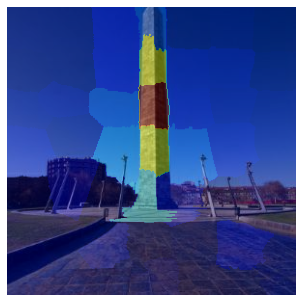

In [476]:
plot_attributions(explanations, np.expand_dims(preproc_img,axis=0), img_size=4., cmap='jet', alpha=0.4,absolute_value=True, clip_percentile=0.5)

In [91]:
METRICS={
    Insertion:{},
    Deletion:{},
    MuFidelity:{},
    AverageStability:{"nb_samples":5}
}

In [92]:
EXPLAINERS=ATTRIBUTION_EXPLAINERS
compute_metrics()

0d2be6df4e1b47cd0a5cae1a738da7ebd725328b.jpeg
1e61fe2b39a6fe93be89a947ac93ed15c84b7744.jpeg
2b11585d8f8e812f132d576caa710c72fdaf6b95.jpeg
319ace1399ee4f529f9e2809b92a3b3c12fb9ed8.jpeg
38b4909ef866cfddd87f9e4d9e6c4cd29a4baaea.jpeg
4937cfae05416563ff976eb79dad6071d2222606.jpeg
6649143d6d6f4e42f23ea1100e5862ec32b71d6b.jpeg
6832bf7f44e9db4fbec1339014fc6245bbd5d20f.jpeg
7081dbd0ab66efa88bdcafee0fd429c7b20f9ad4.jpeg
74e3f3ed5b3dc7e985fae42a41db5f18df5277c3.jpeg
782953c341ad40b1a0aa715e5b951b6aadcb3a25.jpeg
78caed38adf326cea37f03960d804283fe5f9164.jpeg
8f6c0c76a4ba038b28e559fafe2b015c3cd6b39e.jpeg
919d12514a1903b7242210423a0507605a0b28c2.jpeg
9628e7f7e3f9e89ad5c040e29523b78150da7cf1.jpeg
9be6a4974aedf3133ae07d8265c5cd89a098644a.jpeg
b59e7d5f533c680b7e05fbf21b0f67c9f49d9867.jpeg
c90306b60cf4200dc415fa3387dc6c2b2ea619c4.jpeg
d3844aef6f6dd9f1f28a6c969c0fe370334a954a.jpeg
f81aea1c65e9821901c13ea6dd482ce0638d8b0e.jpeg


In [99]:
metric_dict={}
for m in METRICS.keys():
    metric_dict[m.__name__]={}
    for e in EXPLAINERS.keys():
        metric_dict[m.__name__][e.__name__]=[]
           
for image_path in IMAGE_PATHS:
    filehead=image_path.split(".")[0]
    img_folder=os.path.join("imgs",filehead)
    for exp in EXPLAINERS.keys(): 
        with open(os.path.join(img_folder,exp.__name__,"metrics.json"),"r") as f:
            metrics_json=json.load(f)
        for func in METRICS.keys():
            metric_dict[func.__name__][exp.__name__].append(metrics_json[func.__name__])

In [100]:
import pandas as pd

for metric in metric_dict.keys():
    pd.DataFrame.from_dict(metric_dict[metric],orient = 'index', columns=IMAGE_PATHS).transpose().astype("float32").to_csv(metric+".csv")

In [101]:
metric_dict={}
metric_dict=metric_dict.fromkeys([m.__name__ for m in METRICS.keys()],dict().fromkeys([e.__name__ for e in EXPLAINERS.keys()],[]))

In [98]:
metric_dict.keys()

dict_keys(['Insertion', 'Deletion', 'MuFidelity', 'AverageStability'])